# Convolutional autoencoder for image denoising
[See Supplementary Table 3~5 for Model Details](https://static-content.springer.com/esm/art%3A10.1038%2Fs41746-020-00320-4/MediaObjects/41746_2020_320_MOESM1_ESM.pdf)

## Introduction

This example demonstrates how to implement a deep convolutional autoencoder
for image denoising, mapping noisy digits images from the MNIST dataset to
clean digits images. This implementation is based on an original blog post
titled [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
by [François Chollet](https://twitter.com/fchollet).

## Setup

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.datasets import mnist
from keras.models import Model
from keras.callbacks import LearningRateScheduler


def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array, noise_factor = 0.4):
    """Adds random noise to each image in the supplied array."""
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


## Prepare the data

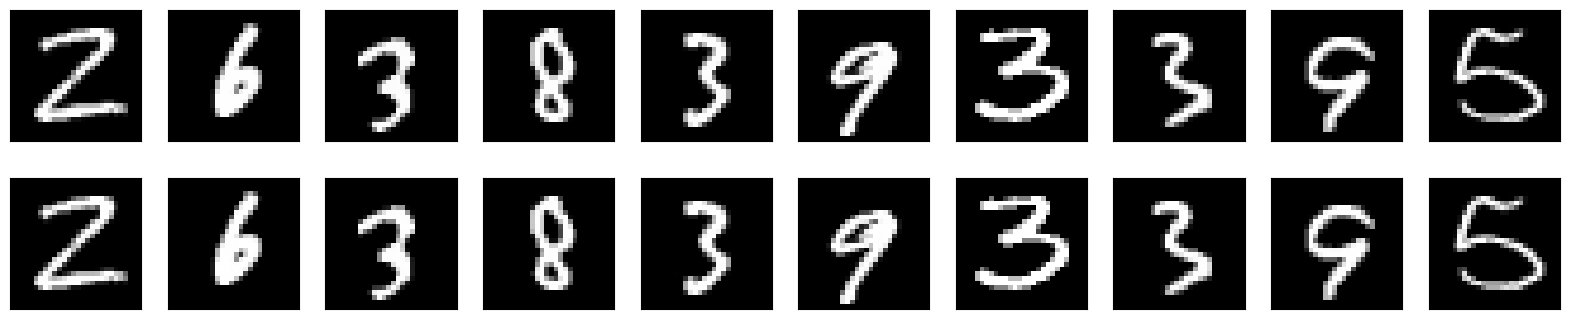

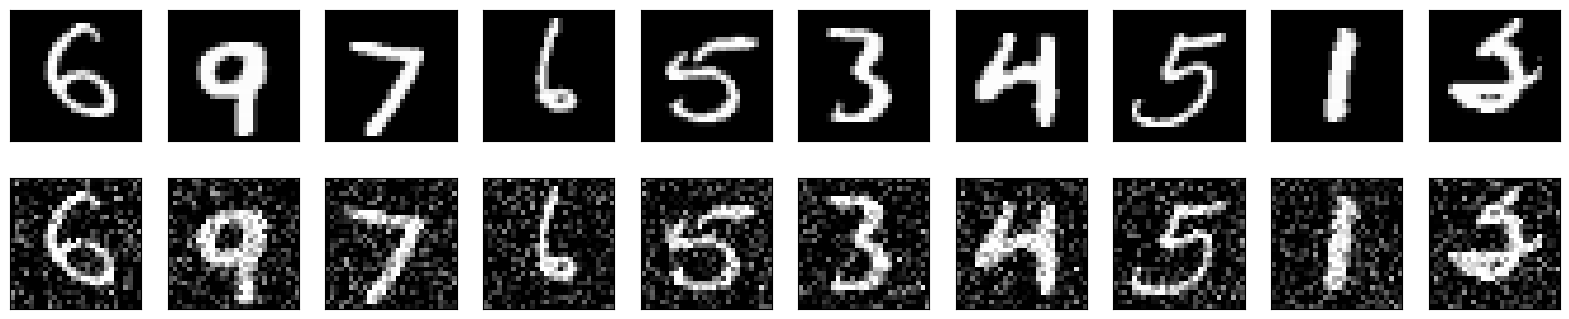

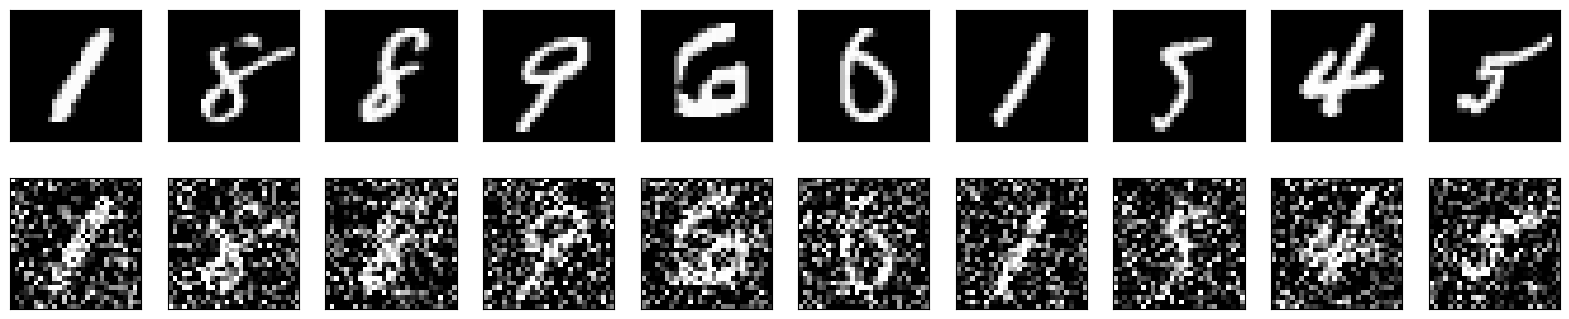

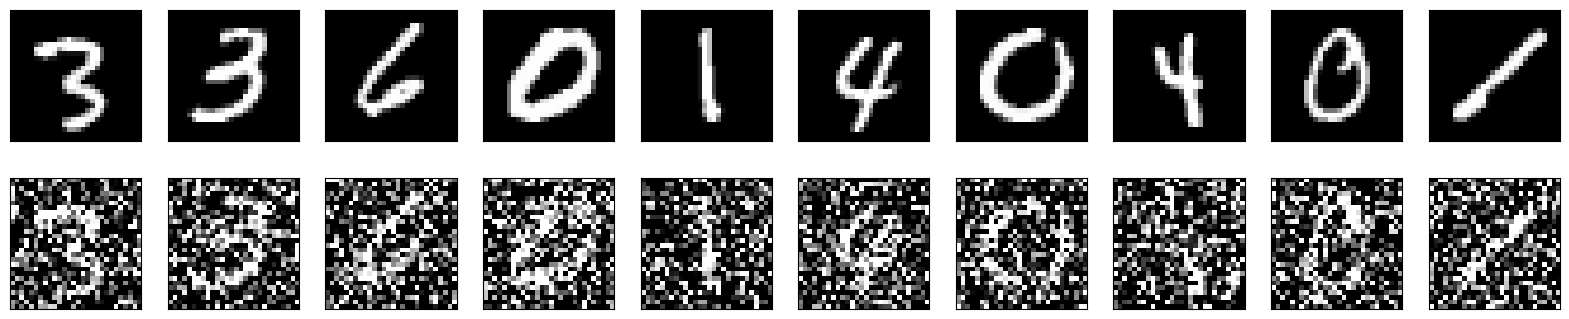

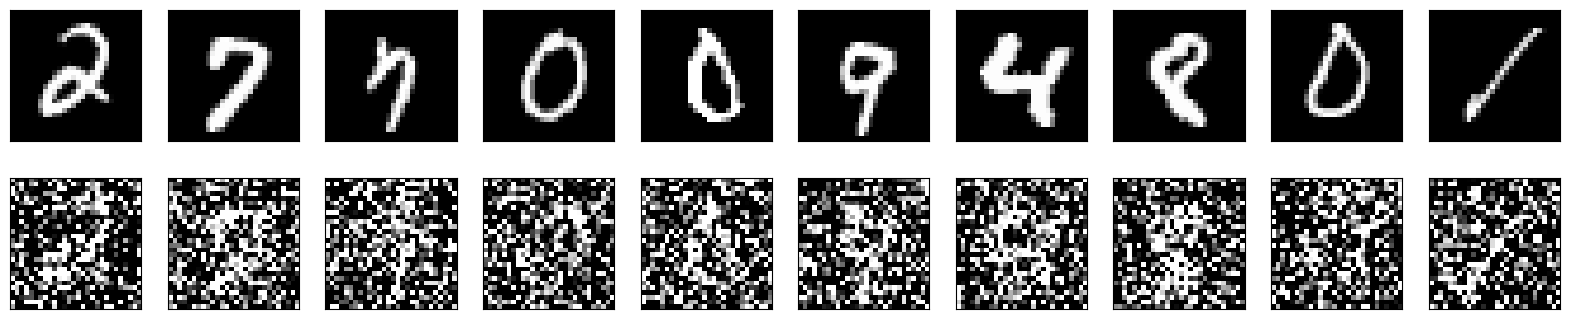

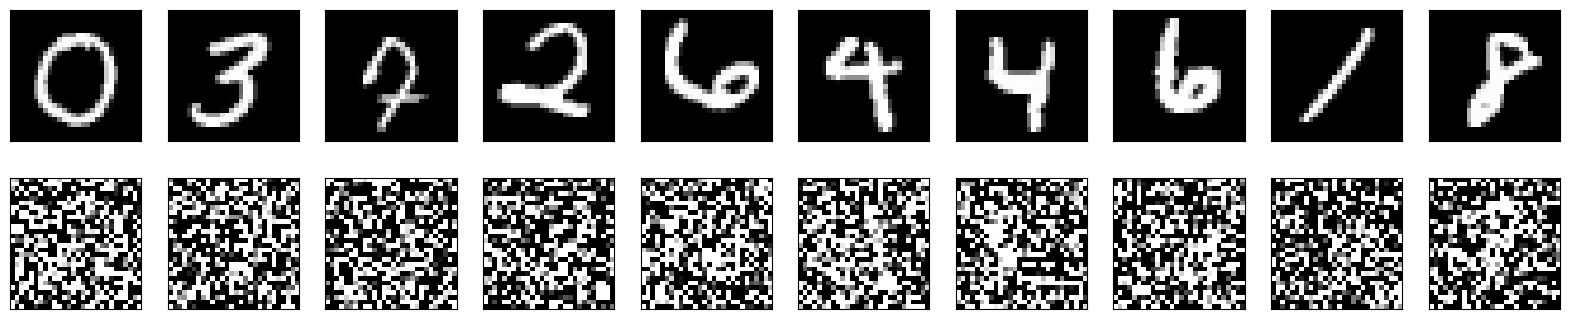

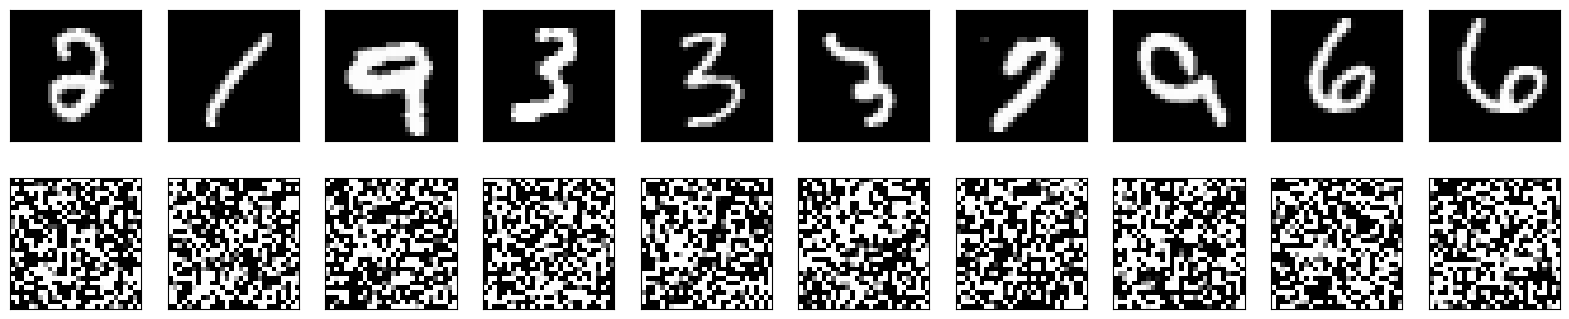

In [ ]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noise_levels = [0.001, 0.25, 0.5, 0.75, 1, 2, 5]
noisy_train_data = []
noisy_test_data = []
for noise_factor in noise_levels:
    noisy_train_data.append(noise(train_data, noise_factor = noise_factor))
    noisy_test_data.append(noise(test_data, noise_factor = noise_factor))

# Display the train data with added noise
for i in range(len(noise_levels)):
    display(train_data, noisy_train_data[i])

# Comcatenate all noisy images to become a whole dataset
simulated_noisy_train_data = np.concatenate(noisy_train_data, axis=0)
simulated_noisy_test_data = np.concatenate(noisy_test_data, axis=0)

## Build the autoencoder

We are going to use the Functional API to build our convolutional autoencoder.

In [22]:
input = layers.Input(shape=(28, 28, 1))

# Encoder: 3 layers of convolutional + pooling
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
# x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder: 3 layers of upsampling + convolutional
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
# x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(1, (3, 3), activation="relu", padding="same")(x)  # Output layer

# Autoencoder Model
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_19 (UpSampling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_20 (UpSampling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,105 (74.63 KB)

 Trainable params: 19,105 (74.63 KB)

 Non-trainable params: 0 (0.00 B)

Now we can train our autoencoder using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images. Notice we are setting up the validation data using the same
format.

In [23]:
# Initial learning rate
initial_lr = 0.01

def lr_schedule(epoch, lr):
    if epoch % 25 == 0 and epoch > 0:
        return max(lr - 0.001, 0.0001)  # Make sure the learning rate does not become negative
    return lr

lr_reduction = LearningRateScheduler(lr_schedule, verbose=1)

# Train Autoencoder
autoencoder.fit(
    # The input to the CDAE was the simulated signal dataset
    # with a Gaussian noise factor of 0.001, 0.5, 0.25, 0.75,
    # 1, 2, and 5 added to corrupt the simulated signals.
    x=simulated_noisy_train_data,

    # The uncorrupted simulated signals are then used as the
    # target for reconstruction.
    y=np.tile(train_data, (len(noise_levels), 1, 1, 1)),
    epochs=3,
    batch_size=128,
    shuffle=True,
    validation_data=(simulated_noisy_test_data, np.tile(test_data, (len(noise_levels), 1, 1, 1))),
    callbacks=[lr_reduction]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/3
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - loss: 0.0377 - val_loss: 0.0314 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/3
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - loss: 0.0311 - val_loss: 0.0305 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/3
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - loss: 0.0304 - val_loss: 0.0303 - learning_rate: 0.0010


Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the
input images.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


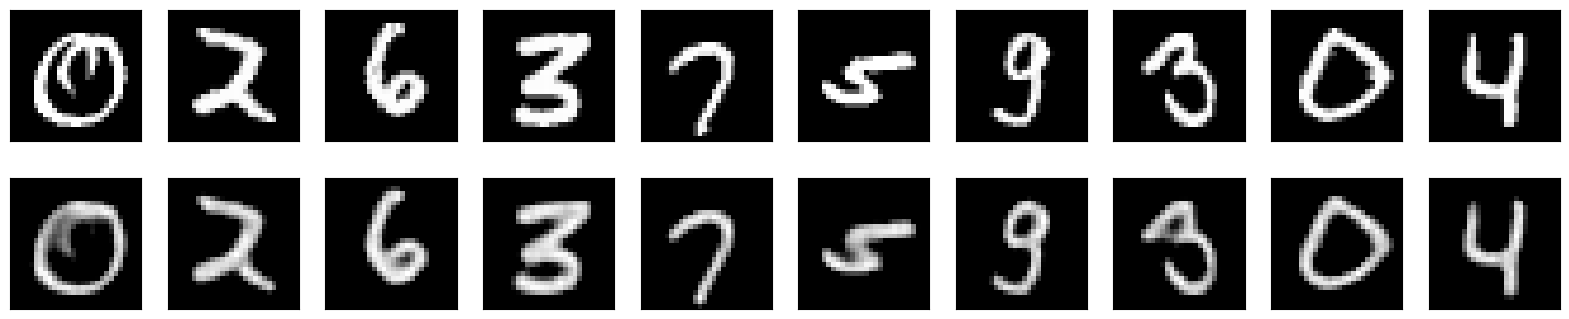

In [24]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

# Transfer Learning